In [3]:
import os.path
import scipy.sparse
import scipy.sparse as sp
import sknetwork as sn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
import umap
from tqdm import trange

import rankbasedlinkage as rbl

/Users/ryandewolfe/miniforge3/envs/rbl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load an ABCD+O graph with 2000 nodes, 50% noise, 20% outliers

In [6]:
edge_list = np.loadtxt("net.dat", dtype="int32") - 1  # Set to 0 indexing
G = sn.data.from_edge_list(edge_list)
label = np.loadtxt('comm.dat',dtype='int32',usecols=(1)) - 2  # Set outliers to -1

## Each node rank's the other nodes according to personalized page rank.
Top k=20 are kept for a knn matrix. Graph is visualized by inverting ranks to distances and passign to UMAP.

In [7]:
def kppr(G, k, alpha):
    n = G.shape[0]
    i = np.empty(n*k, dtype="int32")
    j = np.empty(n*k, dtype="int32")
    data = np.empty(n*k, dtype="float32")

    ranker = sn.ranking.PageRank(damping_factor=alpha, solver="diteration", tol=0.0001, n_iter=10)
    for node in trange(G.shape[0]):
        personalize = np.zeros(G.shape[0])
        personalize[node] = 1
        ppr = ranker.fit_predict(G, weights=personalize)
        top_nodes = np.argsort(ppr)[-k:]  # Take largest k (sort puts in ascending order)
        i[node*k:(node+1)*k] = node
        j[node*k:(node+1)*k] = top_nodes
        data[node*k:(node+1)*k] = ppr[top_nodes]
    
    ppr = scipy.sparse.coo_matrix((data, (i, j)), shape=(n,n))
    ppr = ppr.tocsr()
    return ppr

In [8]:
k = 20

# Make rank graph as KPPR
rank_graph = kppr(G, k, 0.8)
print(f"Rank graph has {np.max(sn.topology.get_connected_components(rank_graph)) + 1} components")

# Make ranks into a distance
dist_graph = (rank_graph + rank_graph.transpose())/2
dist_graph.setdiag(0)
dist_graph.eliminate_zeros()
dist_graph.data = np.max(dist_graph.data) + 0.001 - dist_graph.data

# Embed into 2d for plotting
data = umap.UMAP(metric="precomputed", n_neighbors=15).fit_transform(dist_graph)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:01<00:00, 1965.28it/s]
/Users/ryandewolfe/miniforge3/envs/rbl/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Rank graph has 1 components


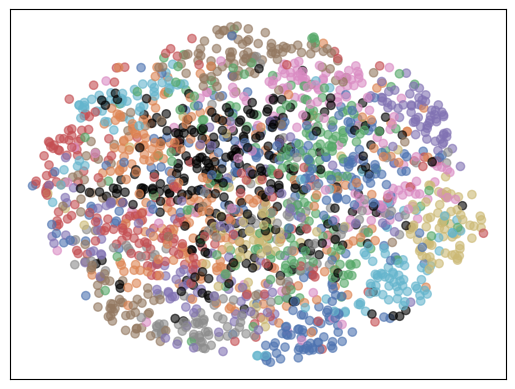

In [9]:
palette = sns.color_palette("deep", np.unique(label).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in label]
plt.scatter(data.T[0], data.T[1], c=colors, alpha=0.6)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

Text(0.5, 1.0, 'Histogram of Cluster sizes')

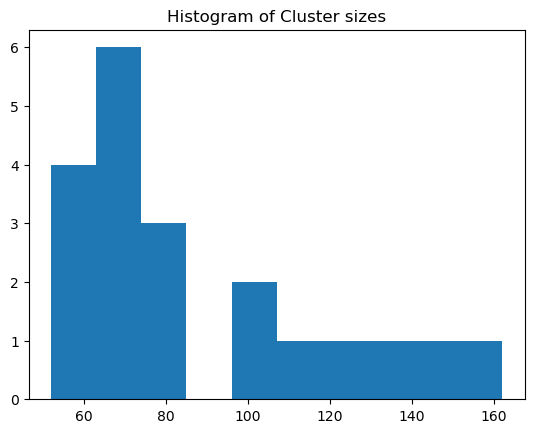

In [10]:
# Cluster sizes
cluster_sizes = np.arange(np.max(label)+1)
for i in range(len(cluster_sizes)):
    cluster_sizes[i] = np.sum(label == i)

plt.hist(cluster_sizes)
plt.title("Histogram of Cluster sizes")

## Run rank based linakge and examine the resulting tree like HDBSCAN.

In [11]:
linkage = rbl.RankBasedLinkage().fit(rank_graph)

Making Friend List


100%|██████████| 2000/2000 [00:00<00:00, 5028.51it/s]


Compute In Sway


100%|██████████| 10674/10674 [00:01<00:00, 6717.65it/s]

Done


In [12]:
linkage_n_cc = np.max(sn.topology.get_connected_components(linkage.linkage)) + 1
print(f"Linkage graph has {linkage_n_cc} components")
if linkage_n_cc >= 2:
    print("Keeping largest cc")
    largest_cc = sn.topology.get_connected_components(linkage.linkage) == 0
    data = data[largest_cc, :]
    linkage.linkage = sn.topology.get_largest_connected_component(linkage.linkage)


Linkage graph has 1 components


<Axes: >

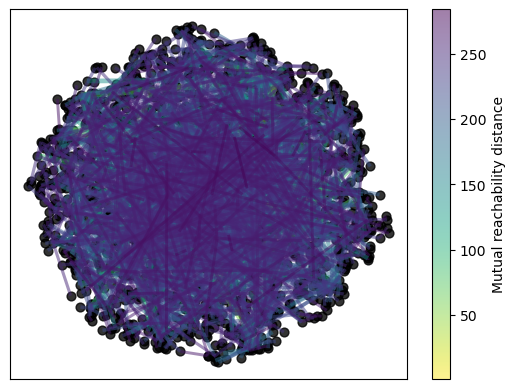

In [13]:
linkage_distances = linkage.linkage.copy()
linkage_distances.data = np.max(linkage_distances.data) + 1 - linkage_distances.data

tree = sp.csgraph.minimum_spanning_tree(linkage_distances)
x, y = tree.nonzero()
min_spanning_tree = np.stack([x, y, tree.data], dtype="float64").transpose()

# Sort edges of the min_spanning_tree by weight
min_spanning_tree = min_spanning_tree[np.argsort(min_spanning_tree.T[2]), :]

rbl_tree = hdbscan.plots.MinimumSpanningTree(min_spanning_tree, data)
rbl_tree.plot()

Text(0.5, 1.0, 'RBL Dendogram. Blue line represents suggest critical T cut')

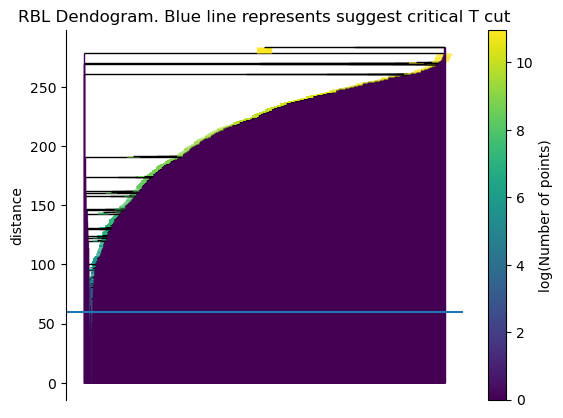

In [15]:
single_linkage_tree = hdbscan._hdbscan_linkage.label(min_spanning_tree)
as_tree = hdbscan.plots.SingleLinkageTree(single_linkage_tree)

# Warning, probably fine but be careful
import sys
sys.setrecursionlimit(10000)

ax = as_tree.plot()

# Get critical suggested T
T = 0
while np.sum(linkage.linkage.data >= T)/2 >= linkage.linkage.shape[0]:
    T += 1
ax.axhline(T)
ax.set_title("RBL Dendogram. Blue line represents suggest critical T cut")

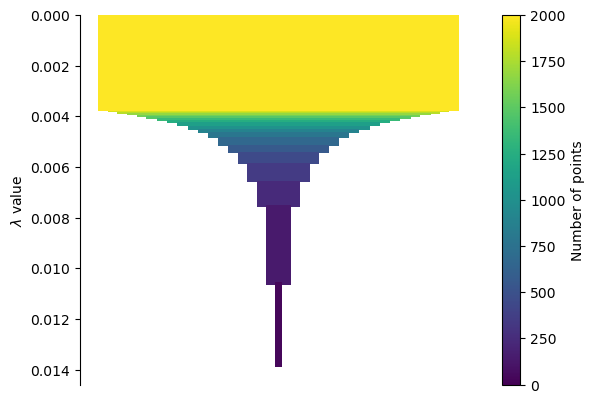

In [16]:
min_cluster_size=15
cluster_selection_method="eom"

condensed_tree = hdbscan._hdbscan_tree.condense_tree(single_linkage_tree, min_cluster_size)

cdt = hdbscan.plots.CondensedTree(condensed_tree, cluster_selection_method=cluster_selection_method)
ax = cdt.plot(select_clusters=True, selection_palette=sns.color_palette())

0  clusters found!


Text(0.5, 1.0, 'RBL clusters with HDBSCAN cluster selection')

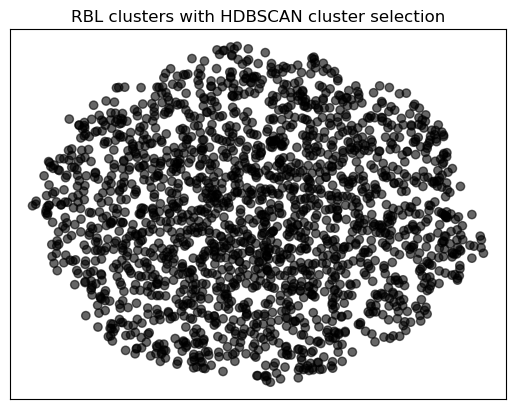

In [19]:
stability_dict = hdbscan._hdbscan_tree.compute_stability(condensed_tree)
predict, probabilities, stabilities = hdbscan._hdbscan_tree.get_clusters(
    condensed_tree,
    stability_dict,
    cluster_selection_method=cluster_selection_method,
    )

#predict = sn.topology.get_connected_components(linkage.linkage)
print(np.max(predict)+1, " clusters found!")

palette = sns.color_palette("deep", np.unique(predict).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in predict]
plt.scatter(data.T[0], data.T[1], c=colors, alpha=0.6)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.title("RBL clusters with HDBSCAN cluster selection")

1  clusters found!


Text(0.5, 1.0, 'RBL clusters with suggested critical cut.')

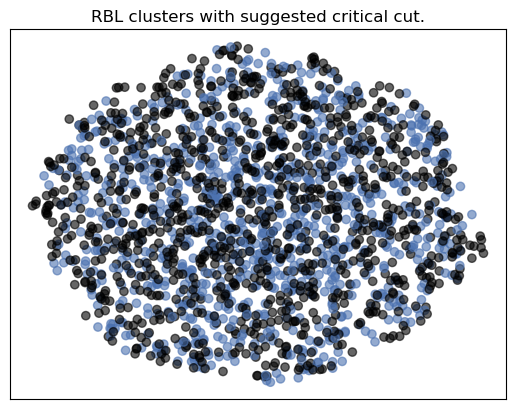

In [20]:
# Suggested clusters
predict = linkage.predict()
print(np.max(predict)+1, " clusters found!")

palette = sns.color_palette("deep", np.unique(predict).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in predict]
plt.scatter(data.T[0], data.T[1], c=colors, alpha=0.6)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.title("RBL clusters with suggested critical cut.")

## Yikes

It's unclear what the problem is, or if there is actually a problem.
It is possible this ranking + method is not well suited to this task.